In [6]:
import os
import tensorflow as tf
from skimage.util import montage
import matplotlib.pyplot as plt

In [7]:
def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames

In [8]:
files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print("Number of training samples: \t", len(train_paths), 
      "\nNumber of validation samples: \t", len(val_paths),
      "\nNumber of test samples: \t\t", len(test_paths))

Number of training samples: 	 320 
Number of validation samples: 	 91 
Number of test samples: 		 47


In [9]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    # image = tf.image.resize(image, (2200, 2200))
    image = tf.image.resize(image, (256, 256))
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # mask = tf.image.resize(mask, (2200, 2200))
    mask = tf.image.resize(mask, (256, 256))
    return mask

def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize(image)
    return image, mask

In [10]:
def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return batches

In [11]:
# Create the dataset
BUFFER_SIZE = 500
BATCH_SIZE = 20

train_batches = create_dataset(train_paths)
test_batches = create_dataset(test_paths)
val_batches = create_dataset(val_paths)

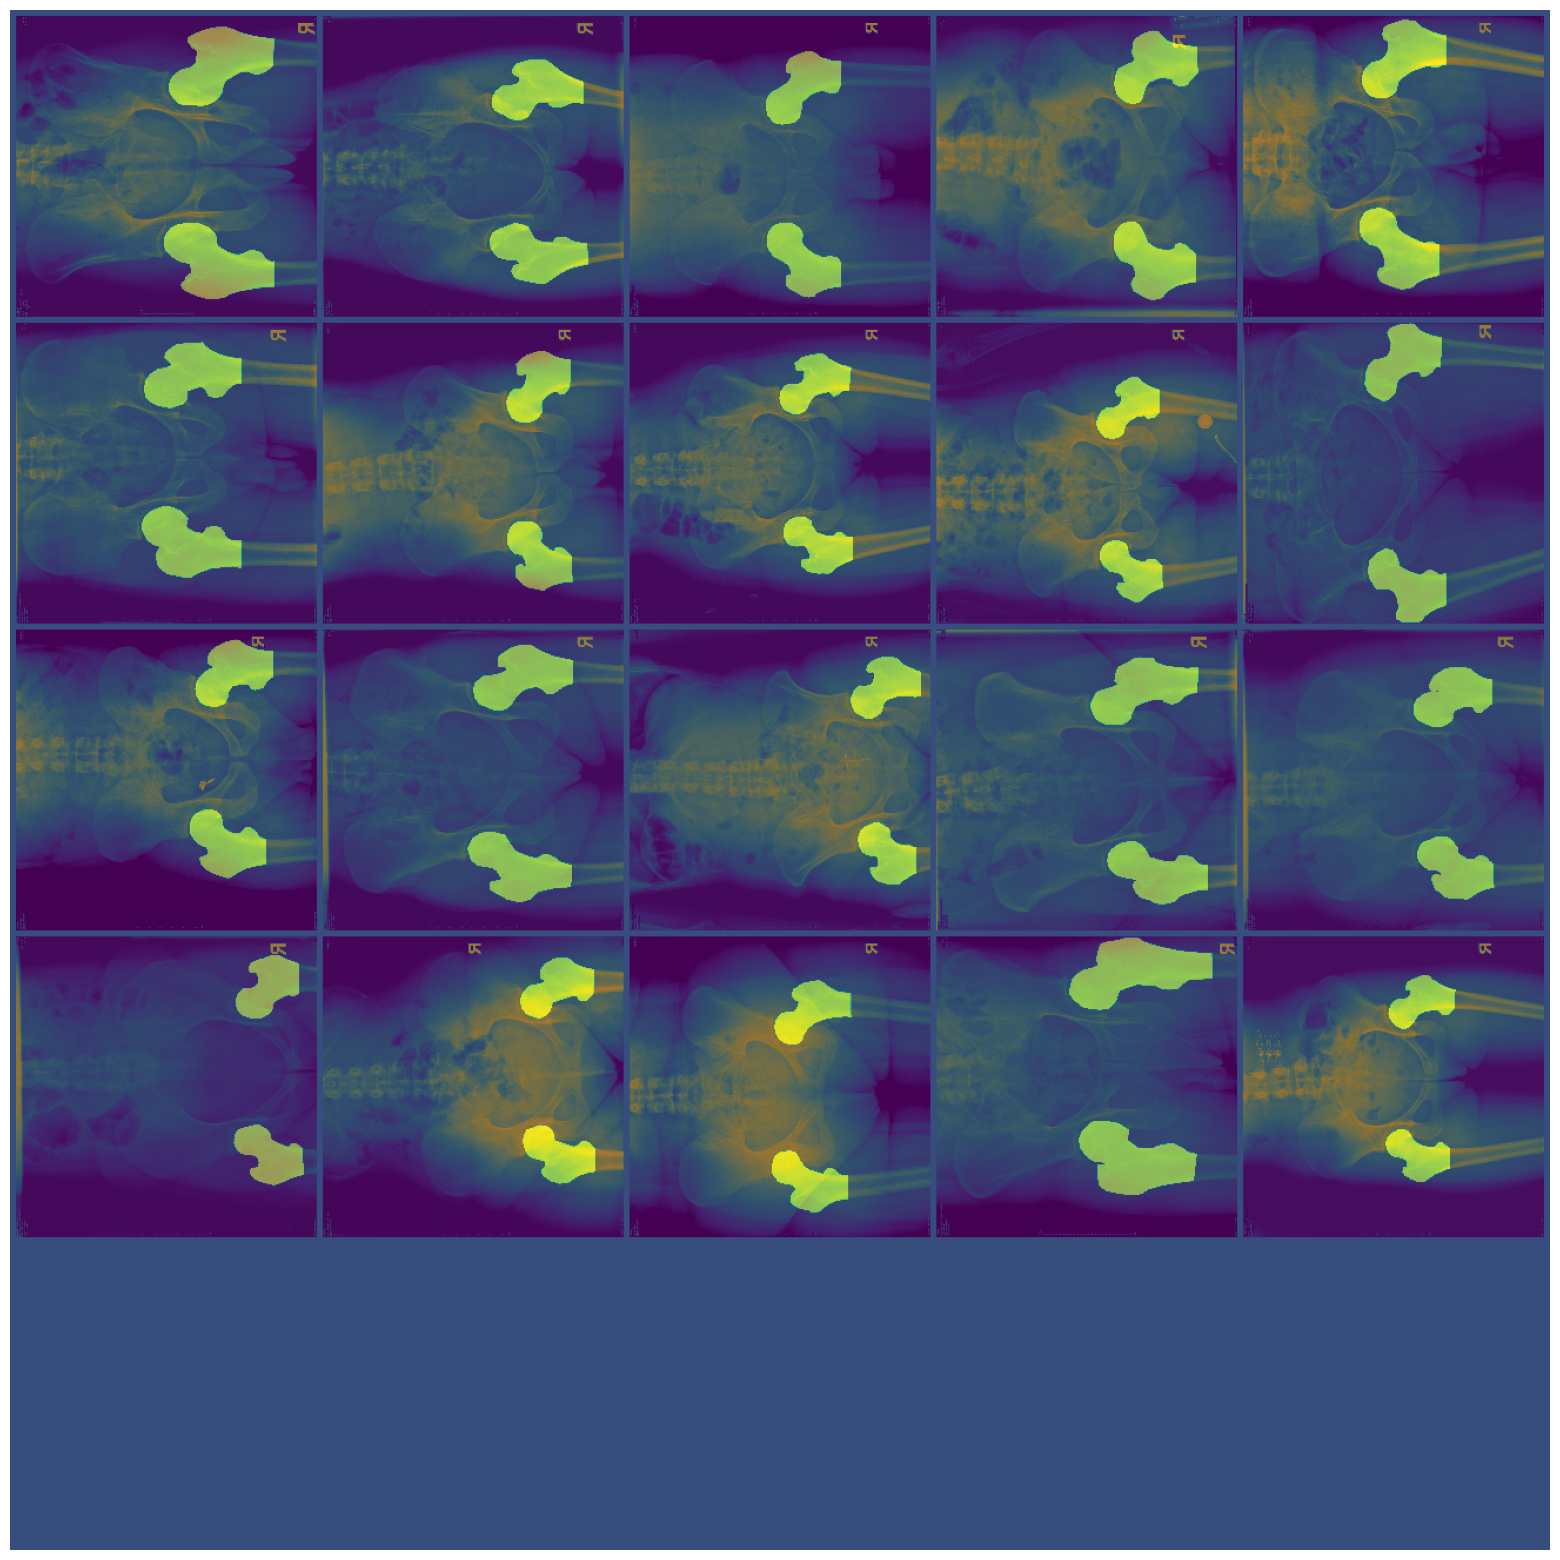

In [12]:
for images, masks in test_batches.take(1):
    montage_images = montage(images.numpy(), channel_axis=3, padding_width=5)
    montage_masks = montage(masks.numpy(), channel_axis=3, padding_width=5)
    fig, axs = plt.subplots(1, figsize=(20, 20))
    axs.imshow(montage_images)
    axs.imshow(montage_masks, alpha=0.5)
    axs.axis("off")
    plt.savefig("test_samples.png")